In [153]:
import numpy as np
import matplotlib.pyplot as plt

# np.random.seed(1)

In [154]:
# graph = [(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
# graph1 = [(graph[i][0] + 4, graph[i][1]+4) for i in range(len(graph))]
# graph2 = [(graph1[i][0] + 4, graph1[i][1]+4) for i in range(len(graph1))]
# graph +=graph1+graph2
# graph+=[(4, 8), (8,12), (4, 12)]
# graph+=[(1, 11)]
# adj = []
# for i in range(12):
#   adj.append([0.]*12)
# for edge in graph:
#   i = edge[0]-1
#   j = edge[1]-1
#   adj[i][j] = 1.
#   adj[j][i] = 1.
# print(adj)

In [155]:
n = 25
adj = np.random.randint(0, 2, (n, n))
np.fill_diagonal(adj, 0, wrap=False)
print(adj)

[[0 1 1 0 1 0 1 1 1 1 1 0 0 1 1 0 1 0 1 0 1 1 1 0 1]
 [0 0 0 1 0 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 1 0 1 1 1]
 [1 1 0 0 1 1 0 1 0 0 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1]
 [0 1 1 0 1 0 0 1 1 1 0 0 1 1 1 1 1 0 0 1 0 0 1 1 0]
 [1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1]
 [1 0 1 1 1 0 1 0 1 1 0 1 1 0 0 1 1 0 1 1 0 0 1 1 1]
 [1 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 1 1 0 1 0 1 0 1 0]
 [1 0 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 0 1 1 1 1 0 0]
 [1 0 1 0 1 1 1 0 0 1 0 1 1 1 0 1 1 0 1 0 1 0 0 0 0]
 [1 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 1 0 1 1 1]
 [0 1 1 0 0 1 1 1 1 0 0 1 0 1 0 1 0 1 0 1 1 1 1 1 0]
 [1 0 0 1 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 1 1 0 1 1 1]
 [0 0 1 1 0 0 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1]
 [0 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 0 1 1 1 0 1 0 1 1]
 [1 1 1 0 1 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 0 1 0 1 1]
 [0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 1]
 [0 0 1 0 1 1 1 0 0 0 0 0 1 1 1 1 0 1 1 1 0 0 1 1 1]
 [1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 1 0 0 1 1]
 [1 0 1 0 0 1 0 1 1 1 1 0 1 0 1 1 1 0 0 0 0 1 

In [156]:
grph = np.array(adj)
def graph_visualize(embs, graph):
  for i in range(len(graph)):
    for j in range(i+1, len(graph)):
      if graph[i][j] == 1:
        xs = [embs[i][0], embs[j][0]]
        ys = [embs[i][1], embs[j][1]]
        plt.text(xs[1], ys[1], str(j+1), fontsize=7)
        plt.text(xs[0], ys[0], str(i+1), fontsize=7)
        plt.plot(xs, ys, marker = 'o')
  plt.show()

In [157]:
import math
class DistanceEmbedding:
  def __init__(self, graph, dim=-1, eps=0):
    '''
    graph:numpy array is adjacency matrix for graph
    '''
    self.graph = graph
    self.n = len(graph)
    if dim == -1:
      dim = round((2*n)**0.5)
    self.eps = eps
    self.f_large_c = -math.e ** (-eps-1)
    self.f_small_c = self.f_large_c / (eps + 1)
    bounds = min(self.n ** (1 / dim), 1.4)
    # self.embeddings = np.random.uniform(-bounds, bounds, (self.n, dim))
    self.embeddings = self.precalc_embs(-bounds, bounds, (self.n, dim))
    self.emb_grad = np.zeros(self.embeddings.shape)

  def forward(self):
    self.distances = np.empty(self.graph.shape)
    loss = 0
    for i in range(self.n):
      for j in range(i + 1, self.n):
        dist = self.distance(self.embeddings[i], self.embeddings[j])
        loss += self.loss(dist, self.graph[i][j])
        self.distances[i][j] = dist
        self.distances[j][i] = dist
    return loss

  def backward(self):
    back_distances = None
    for i in range(self.n):
      for j in range(i + 1, self.n):
        x = self.distances[i][j]
        if self.graph[i][j]:
          back_distances = 1 * (1+self.sign(self.f_large(x))) * (math.e**(x-2))
        else:
          back_distances = 0.5 * (1+self.sign(self.f_small(x))) * -(1 + 1 / x) / ((math.e**x)*x)

        emb = (self.embeddings[i]-self.embeddings[j]) / self.distances[i][j] * back_distances
        self.emb_grad[i] += emb
        self.emb_grad[j] -= emb
  def step(self, l_r):
    self.embeddings -= l_r * self.emb_grad

  def zero_grad(self):
    self.emb_grad = np.zeros(self.emb_grad.shape)

  def loss(self, x, c):
    return max((1 - c) * self.f_small(x), c * self.f_large(x))

  def f_small(self, x):
    return 1 / (x * (math.e ** x)) + self.f_small_c

  def f_large(self, x):
    return math.e ** (x - 2) + self.f_large_c

  def precalc_embs(self, l, r, shape):
    embs = np.empty(shape)
    visited = [False] * self.n
    for i in range(self.n):
      if visited[i]:
        continue
      visited[i] = True
      embs[i] = np.random.uniform(l, r, shape[1])
      q = [i]
      while len(q) > 0:
        cur = q[0]
        for j in range(self.n):
          if self.graph[cur][j] == 1 and not visited[j]:
            a = np.random.uniform(-1, 1, (shape[1]))
            a /= np.sum(a ** 2)
            embs[j] = embs[cur] - a
            visited[j] = True
            q.append(j)
        del q[0]
    return embs


  @staticmethod
  def distance(x, y):
    return np.sum((x-y)**2)**0.5

  @staticmethod
  def sign(x):
    if x < 0:
      return -1.
    if x > 0:
      return 1
    return 0


26.65128858742428


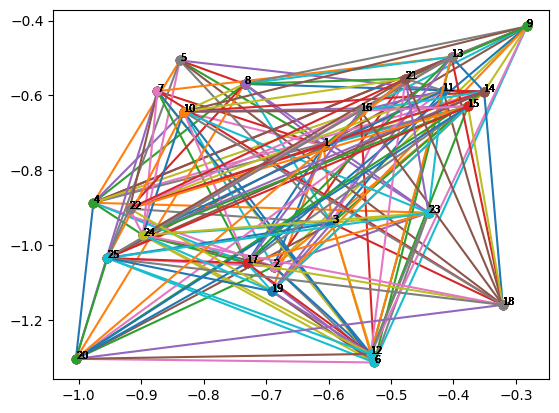

In [158]:
distEmb = DistanceEmbedding(grph)
print(distEmb.forward())
start_emb = distEmb.embeddings
graph_visualize(start_emb, grph)

26.65128858742428
14.05852173607936
12.686223748648565
11.4395958042713
10.425778830050689
9.419914498059795
8.655544505588807
7.956084400704871
7.547463157369248
7.058272905965376
6.6725836765528665
6.259987802551829
5.908557876350912
5.547353549272006
5.2458399179731705
4.988337191900701
4.802123161823346
4.467094322456729
4.450337807328475
4.065423134518449
4.0419705373123005
3.721142886943066
3.7136230522723213
3.3826670050837793
3.407633478637092
3.0273989140181703
3.0860164122898226
2.7321605659084174
2.7224024010322907
2.4568726615447725
2.4154681373611457
2.1829978276955004
2.1661215617138168
1.962894265889895
1.9512806361343726
1.8125599011918105
1.7968661319900971
1.665378659546839
1.7012297739870643
1.5591305200908807
1.6993376222519012
1.4466790741553548
1.6231568933510885
1.3717029585683669
1.6330125821323551
1.3009361496416045
1.4947433091941642
1.230097292614653
1.4601304756218965
1.162682258127635
1.220327230583456
1.1392728998534145
1.1172646108199618
1.170418269227528

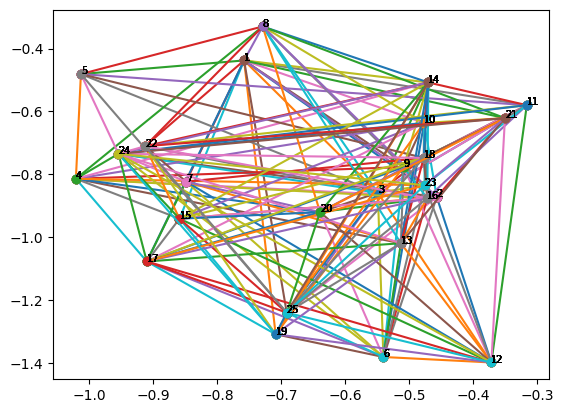

In [159]:
l_r = 0.02
last_loss = 1000000
for i in range(2000):
  loss = distEmb.forward()
  distEmb.backward()
  distEmb.step(l_r)
  distEmb.zero_grad()
  if i%250==0:
    l_r /= 2
  print(loss)
  last_loss = loss
end_emb = distEmb.embeddings
graph_visualize(end_emb, grph)

In [160]:
graph = grph
distances = np.empty(graph.shape)
for i in range(len(graph)):
  for j in range(i + 1, len(graph)):
    dist = DistanceEmbedding.distance(end_emb[i], end_emb[j])
    distances[i][j] = dist
    distances[j][i] = dist
for i in range(len(graph)):
  for j in range(i+1, len(graph)):
    x = distances[i][j]
    dlt = 0
    if x > 1+dlt and graph[i][j]==1:
      print(f"Vertices {i} and {j} should be connected! But distances is equal to {x}")
    if x <= 1-dlt and graph[i][j]==0:
      print(f"Vertices {i} and {j} should be disconnected! But distances is equal to {x}")